## Import Libraries

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from google.colab import drive, files
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

## Import Datasets

In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
print('Number of Train Sample: ', train.shape[0])
print('Number of Test Sample: ', test.shape[0])

Number of Train Sample:  42000
Number of Test Sample:  28000


## Preprocessing

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

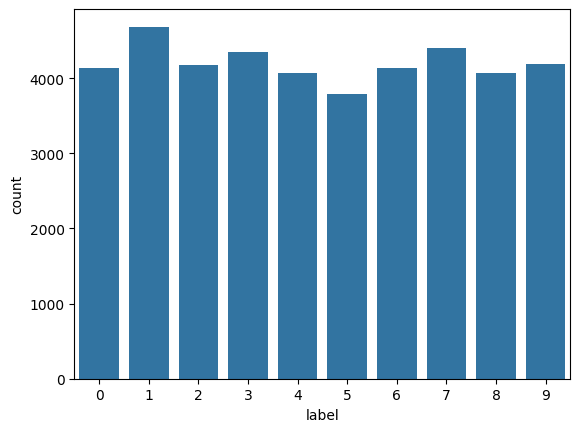

In [15]:
# use only label column for Y_train
Y_train = train["label"]

# Drop the label column for X_train
X_train = train.drop(labels = ["label"],axis = 1)

# Let's see what is the Y_train looks like
sns.countplot(x=Y_train)
Y_train.value_counts()

In [16]:
# Check missing values
print('Missing Values Train-set :',train.isnull().values.any())
print('Missing Values Test-set :',test.isnull().values.any())

Missing Values Train-set : False
Missing Values Test-set : False


In [17]:
# Data Normalization
X_train = X_train / 255.0
X_test = test / 255.0

# Data Reshape
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

# Encoding
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = 10)

In [18]:
# Data Splitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.1, random_state=7)

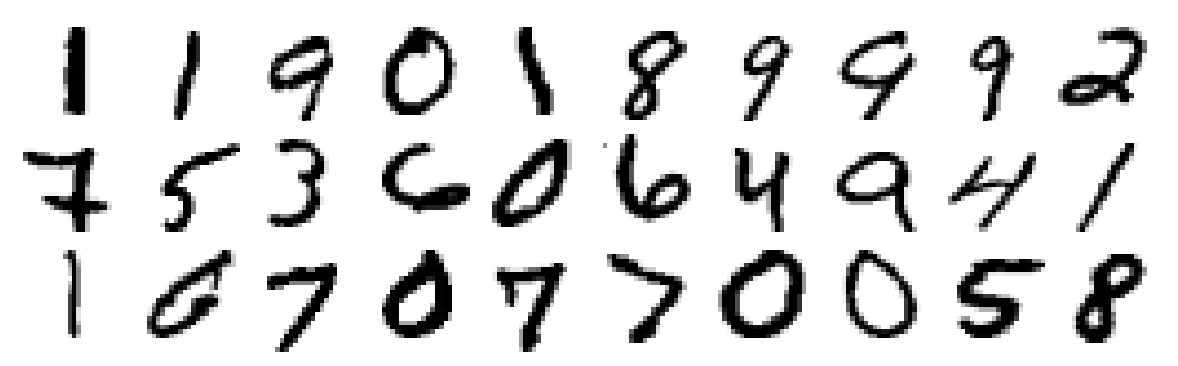

In [19]:
# Preview Images
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
)

train_datagen.fit(X_train)

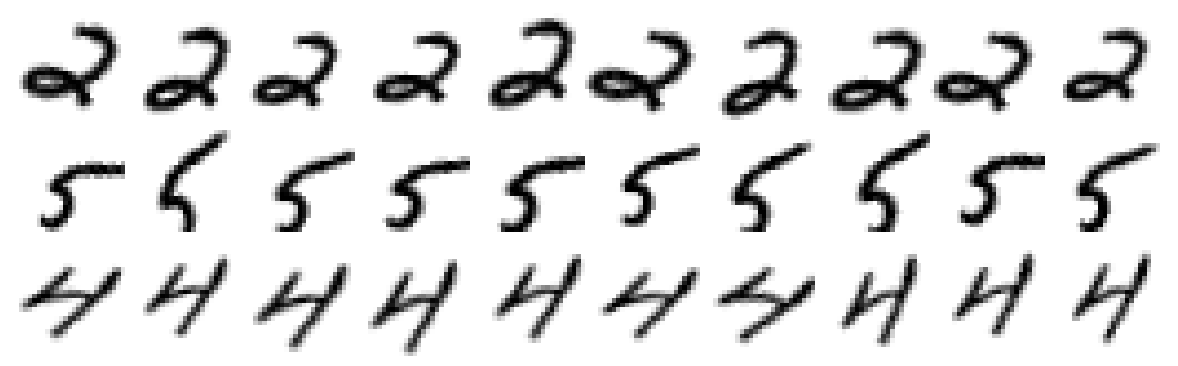

In [21]:
# Preview Augmented Images
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = train_datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

## Define Model

In [22]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

## Model Compilation

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9,staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                        

## Model Training

In [24]:
batch_size = 82
epochs = 50

history = model.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=early_stop)

Epoch 1/50
460/460 - 310s - loss: 2.3213 - accuracy: 0.8887 - val_loss: 0.7053 - val_accuracy: 0.9526 - 310s/epoch - 673ms/step
Epoch 2/50
460/460 - 305s - loss: 0.4925 - accuracy: 0.9559 - val_loss: 0.3205 - val_accuracy: 0.9833 - 305s/epoch - 664ms/step
Epoch 3/50
460/460 - 302s - loss: 0.3819 - accuracy: 0.9618 - val_loss: 0.3192 - val_accuracy: 0.9821 - 302s/epoch - 657ms/step
Epoch 4/50
460/460 - 296s - loss: 0.3633 - accuracy: 0.9629 - val_loss: 0.3142 - val_accuracy: 0.9795 - 296s/epoch - 644ms/step
Epoch 5/50


KeyboardInterrupt: 

## Model Evaluation

In [ ]:
results = np.zeros((X_test.shape[0],10))
results = results + model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("mnist_digit_recognizer.csv",index=False)

## Predictions

In [ ]:
# Preview Predictions
plt.figure(figsize=(15,6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()